# TREE CROWN DETECTION AND DELINEATION 

A exploration of the approach discussed in SHAPE-BASED TREE CROWN DETECTION AND DELINEATION IN HIGH SPATIAL RESOLUTION AERIAL IMAGERY (Chen et. al.) is applied in splitting large contours for tree detection in aerial images.  

Simple image preprocessing is performed before contour detection. Image contrast adjustment is perfomed via a colour space transform (grayscale) and contrast limited adaptive histogram equalization. The watershed algorithm is used to find the contours in the processed image.

A prototype of the Chen et al's paper followed contour detection through nodularities. Large contours are identified as those with small nodularities. A mask of the large contour is created and a structure element i.e. normal tree size is slid across large contours to generate a similarity map. The peaks i.e.centers in the map are found. 

Contour delineation steps using geometry are applied to find split the large contours for overlapping peaks that are close together.

In [1]:
# Import packages
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import img_as_float
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from scipy.spatial import distance
from sympy.geometry import Circle, Point
from scipy.stats import itemfreq
import os
%matplotlib inline 

In [2]:
# Input parameters
CWD = os.getcwd()
INPUT_PATH = '\\Data\\'
IMG_PATH = CWD+INPUT_PATH+'original_img.jpg'

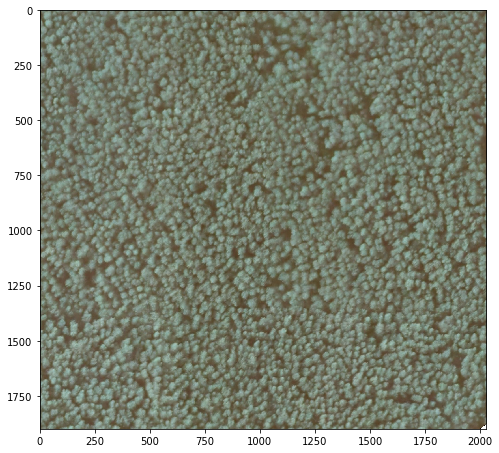

In [3]:
# Load image
img = cv2.imread(IMG_PATH)

plt.figure(figsize = (8,8))
plt.imshow(img, cmap='gray')
plt.show()

## Image Preprocessing

In [4]:
# Colour Space Transform - Convert image to grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Histogram Equalization - Enhance image contrasts globally
img_equ = cv2.equalizeHist(img_gray)

# Adaptive Histogram Equalization - Enhance image contrasts by Contrast Limited Adaptive Histogram Equalization
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img_ada_equ = clahe.apply(img_gray)

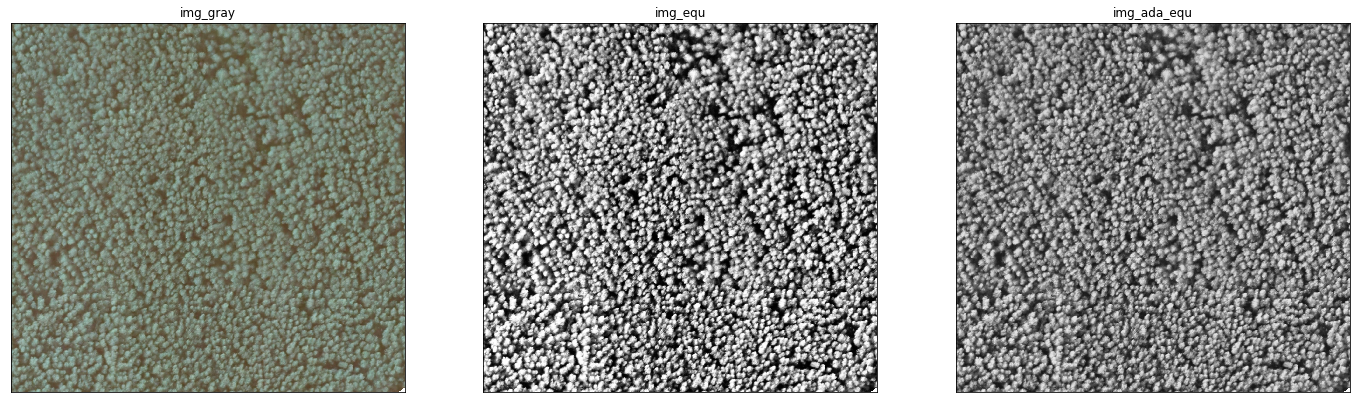

In [5]:
img_dict = {"img_gray":img, "img_equ":img_equ, "img_ada_equ":img_ada_equ}

i=0
fig = plt.figure(figsize=(24, 8))
for key, value in img_dict.items():
    ax = fig.add_subplot(1, 3, i+1)
    i+=1
    plt.imshow(value, cmap='gray')
    ax.set_title(key)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()

In [6]:
# De-noising(apply appropriate convolution kernels)
dst = cv2.fastNlMeansDenoising(img_ada_equ, None, 10, 7, 21)

# Smoothing and Filtering (anisotropic, gaussian)
blur = cv2.bilateralFilter(dst, 9, 75, 75)

# Binarization - Local Otsu Threshold
ret, thresh = cv2.threshold(blur, 127, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

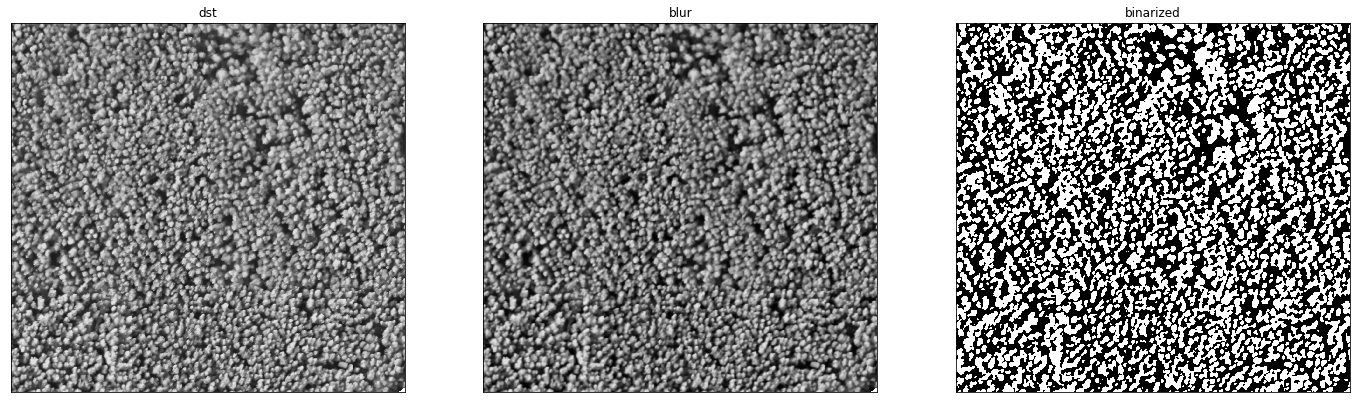

In [7]:
img_dict = {"dst":dst, "blur":blur, "binarized":thresh}

i=0
fig = plt.figure(figsize=(24, 8))
for key, value in img_dict.items():
    ax = fig.add_subplot(1, 3, i+1)
    i+=1
    plt.imshow(value, cmap='gray')
    ax.set_title(key)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()

### Watershed Algorithm

In [8]:
# Morphological Operations & Watershed Algorithm
# noise removal
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)
# plt.imshow(sure_bg, cmap="gray")

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.1*dist_transform.max(), 255, 0)
# plt.imshow(sure_fg, cmap="gray")

# Finding unknown region
sure_fg = np.uint8(sure_fg)
# plt.imshow(sure_fg, cmap="gray")
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Now mark the region of unknown with zero
markers[unknown == 255] = 0

markers = cv2.watershed(img, markers)
img[markers == -1] = [0, 255, 0]

# plt.imshow(img, cmap="gray")

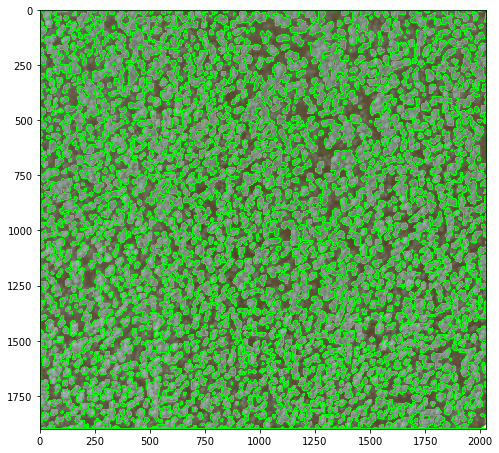

In [9]:
# Convert the markers into contours
m = cv2.convertScaleAbs(markers) #the output is converted to unit8 image
ret3, thresh3 = cv2.threshold(m, 1, 255, cv2.THRESH_BINARY)
thresh_inv = cv2.bitwise_not(thresh3)

cnts, _ = cv2.findContours(thresh_inv, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img, cnts, -1, (0, 255, 0), 3)

plt.figure(figsize = (8,8))
plt.imshow(img)
plt.show()

## Large Crown Identification & Delineation

In [10]:
# helper functions from cnts_split.py
import cnts_split as cs
# import tqdm

In [11]:
# find area of all contours and min circle area
area = []
mincircle_area = []
mincircle_center = []
mincircle_radius = []
nod = []
cnts_update = []

for c in cnts:
    c_area = cv2.contourArea(c)
    if c_area > 0:
        area.append(c_area)

        (x, y), radius = cv2.minEnclosingCircle(c)

        # convert all values to int
        center = (int(x), int(y))
        radius = int(radius)

        mincircle_center.append(center)
        mincircle_radius.append(radius)
        mincircle_area.append(np.pi*radius*radius)
        cnts_update.append(c)

In [12]:
# plot distribution of contour areas to find what is the normal crown size
area = np.array(area)
#plt.hist(area[area<30000], bins=100, alpha=0.5)

mincircle_area = np.array(mincircle_area)

# Find nodularity of contours and plot distribution
nod = area/mincircle_area
#plt.hist(nod, bins=100, alpha=0.5)

# Find small nodularity index i.e. tree clumps
ind = np.where(nod < np.mean(nod) + np.std(nod))
ind = np.array(ind)

# Find average structure element
ind_norm = np.where(nod > np.mean(nod) + np.std(nod))

# setup structure element - square approximation to circle
SE_radius = int(np.sqrt((800/np.pi))) #int(area[ind_norm].mean()) # TODO: tweak this i.e. how to average SE size

# window = int(np.sqrt(np.pi*SE_radius*SE_radius)) # area of circle = area of sq
window = int(np.sqrt(np.square(SE_radius*2)/2)) # circle diameter = sq diagonal


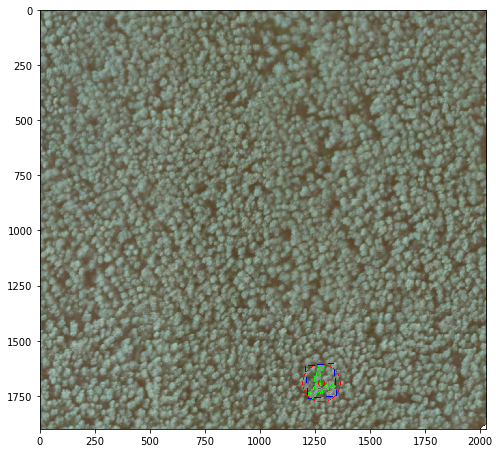

In [13]:
# INDIVIDUAL CONTOUR TEST - FOR VISUALISATION ONLY
test = 204 #598 #204
img = cv2.imread(IMG_PATH)
cv2.drawContours(img, cnts_update[test], -1, (0, 255, 0), 3)
cv2.circle(img, mincircle_center[test], mincircle_radius[test], (255, 0, 0), 2)
cv2.circle(img, mincircle_center[test], SE_radius, (255, 0, 0), 2)

# Find number of SE in each big contours
rect = cv2.minAreaRect(cnts_update[test])
box = cv2.boxPoints(rect)
box = np.int0(box)
cv2.drawContours(img, [box], 0, (0, 0, 255), 2)

plt.figure(figsize = (8,8))
plt.imshow(img)
plt.show()

In [14]:
trees_cnts = []
large_cnts = []
large_cnts_new = []
for i in range(len(cnts_update)):

    print("Processing Contour", i)

    rect = cv2.minAreaRect(cnts_update[i])
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    if nod[i] < 0.55:
        large_cnts.append(i)
        
        # generate similarity map
        mask = cs.sliding_window(img0=img_gray.shape[0], img1=img_gray.shape[1],
                                 stepSize=2, windowSize=18,
                                 box=box, cnt=cnts_update[i])
        
        # find peaks in similarity map
        peak = cs.find_peaks(mask=mask, iri_bri=10)

        if len(peak) == 0:
            trees_cnts.append(cnts_update[i])
            continue

        # find peaks centers in peaks
        peak_centers = cs.find_peak_centers(img0=img_gray.shape[0], img1=img_gray.shape[1],
                                            peak=peak)

        if len(peak_centers) == 1:
            trees_cnts.append(cnts_update[i])
            continue

        cnts_break = cs.delineate_cnt(img0=img_gray.shape[0], img1=img_gray.shape[1],
                                      peak_centers=peak_centers, SE_radius=SE_radius,
                                      box=box, cnt=cnts_update[i])

        if len(cnts_break) == 1:
            trees_cnts.append(cnts_update[i])
        else:
            trees_cnts.extend(cnts_break)

        print("The large contour was split into ", len(cnts_break), "contours")

    else:

        trees_cnts.append(cnts_update[i])


Processing Contour 0
Processing Contour 1
Processing Contour 2
Processing Contour 3
Processing Contour 4
Processing Contour 5
Processing Contour 6
Processing Contour 7
Processing Contour 8
Processing Contour 9
Processing Contour 10
Processing Contour 11
Processing Contour 12
Processing Contour 13
Processing Contour 14
Processing Contour 15
Processing Contour 16
Processing Contour 17
Processing Contour 18
Processing Contour 19
Processing Contour 20
Processing Contour 21
Processing Contour 22
Processing Contour 23
Processing Contour 24
Processing Contour 25
Processing Contour 26
Processing Contour 27
Processing Contour 28
Processing Contour 29
Processing Contour 30
Processing Contour 31
Processing Contour 32
Processing Contour 33
Processing Contour 34
Processing Contour 35
Processing Contour 36
Processing Contour 37
Processing Contour 38
Processing Contour 39
Processing Contour 40
Processing Contour 41
The large contour was split into  2 contours
Processing Contour 42
Processing Contour 

Processing Contour 266
Processing Contour 267
The large contour was split into  5 contours
Processing Contour 268
Processing Contour 269
Processing Contour 270
Processing Contour 271
Processing Contour 272
Processing Contour 273
Processing Contour 274
Processing Contour 275
Processing Contour 276
Processing Contour 277
The large contour was split into  2 contours
Processing Contour 278
Processing Contour 279
The large contour was split into  1 contours
Processing Contour 280
The large contour was split into  1 contours
Processing Contour 281
The large contour was split into  5 contours
Processing Contour 282
Processing Contour 283
Processing Contour 284
The large contour was split into  4 contours
Processing Contour 285
Processing Contour 286
Processing Contour 287
Processing Contour 288
Processing Contour 289
Processing Contour 290
Processing Contour 291
The large contour was split into  1 contours
Processing Contour 292
Processing Contour 293
Processing Contour 294
The large contour 

The large contour was split into  2 contours
Processing Contour 517
Processing Contour 518
The large contour was split into  1 contours
Processing Contour 519
Processing Contour 520
Processing Contour 521
Processing Contour 522
Processing Contour 523
Processing Contour 524
Processing Contour 525
Processing Contour 526
Processing Contour 527
Processing Contour 528
The large contour was split into  4 contours
Processing Contour 529
Processing Contour 530
Processing Contour 531
Processing Contour 532
Processing Contour 533
Processing Contour 534
Processing Contour 535
Processing Contour 536
Processing Contour 537
The large contour was split into  7 contours
Processing Contour 538
Processing Contour 539
Processing Contour 540
Processing Contour 541
Processing Contour 542
Processing Contour 543
The large contour was split into  4 contours
Processing Contour 544
Processing Contour 545
Processing Contour 546
Processing Contour 547
The large contour was split into  2 contours
Processing Contou

The large contour was split into  11 contours
Processing Contour 766
Processing Contour 767
Processing Contour 768
Processing Contour 769
Processing Contour 770
Processing Contour 771
The large contour was split into  2 contours
Processing Contour 772
Processing Contour 773
Processing Contour 774
Processing Contour 775
Processing Contour 776
Processing Contour 777
Processing Contour 778
Processing Contour 779
The large contour was split into  4 contours
Processing Contour 780
Processing Contour 781
Processing Contour 782
The large contour was split into  8 contours
Processing Contour 783
Processing Contour 784
Processing Contour 785
Processing Contour 786
Processing Contour 787
Processing Contour 788
Processing Contour 789
Processing Contour 790
The large contour was split into  2 contours
Processing Contour 791
The large contour was split into  2 contours
Processing Contour 792
Processing Contour 793
Processing Contour 794
Processing Contour 795
Processing Contour 796
Processing Conto

Processing Contour 1017
Processing Contour 1018
Processing Contour 1019
Processing Contour 1020
Processing Contour 1021
Processing Contour 1022
The large contour was split into  1 contours
Processing Contour 1023
Processing Contour 1024
Processing Contour 1025
Processing Contour 1026
Processing Contour 1027
The large contour was split into  2 contours
Processing Contour 1028
The large contour was split into  3 contours
Processing Contour 1029
Processing Contour 1030
Processing Contour 1031
Processing Contour 1032
The large contour was split into  1 contours
Processing Contour 1033
Processing Contour 1034
Processing Contour 1035
Processing Contour 1036
Processing Contour 1037
Processing Contour 1038
Processing Contour 1039
Processing Contour 1040
Processing Contour 1041
Processing Contour 1042
Processing Contour 1043
Processing Contour 1044
Processing Contour 1045
Processing Contour 1046
Processing Contour 1047
The large contour was split into  8 contours
Processing Contour 1048
Process

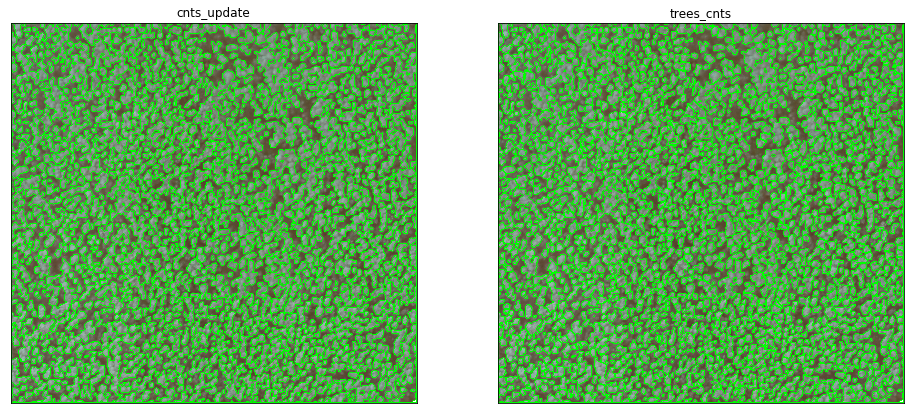

In [17]:
# visalize results - notice the right image which contains split large contours
img_dict = {"cnts_update":cnts_update, "trees_cnts":trees_cnts}

i=0
fig = plt.figure(figsize=(16, 8))
for key, value in img_dict.items():
    ax = fig.add_subplot(1, 2, i+1)
    i+=1
    img = cv2.imread(IMG_PATH)
    cv2.drawContours(img, value, -1, (0, 255, 0), 3)
    plt.imshow(img, cmap='gray')
    ax.set_title(key)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()